In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from azure.storage.blob import BlobServiceClient
import joblib


In [99]:
connection_string = 'DefaultEndpointsProtocol=https;AccountName=stockanomaly;AccountKey=XCfgpf5eX6ZK1OBnGo+/DzOZQ8WsApNYvLuOGn2TbalNN3tpvvOQjjXGXYJbJ5xc9Wmip6LoOysj+AStfWHBNA==;EndpointSuffix=core.windows.net'
blob_service_client = BlobServiceClient.from_connection_string(connection_string)



In [100]:
container_name = "containerstock"
container_client = blob_service_client.get_container_client(container_name)


In [101]:
from io import BytesIO

blob_name = "MSFT.csv"
blob_client = container_client.get_blob_client(blob_name)
blob_stream = blob_client.download_blob().readall()
df = pd.read_csv(BytesIO(blob_stream))
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400


In [102]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [103]:
df["Date"]=pd.to_datetime(df["Date"],errors='coerce')

In [104]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [105]:
duplicate = df[df.duplicated()]
duplicate

,Date,Open,High,Low,Close,Adj Close,Volume


Text(0.5, 1.0, 'Change in the stock price of Google over the years')

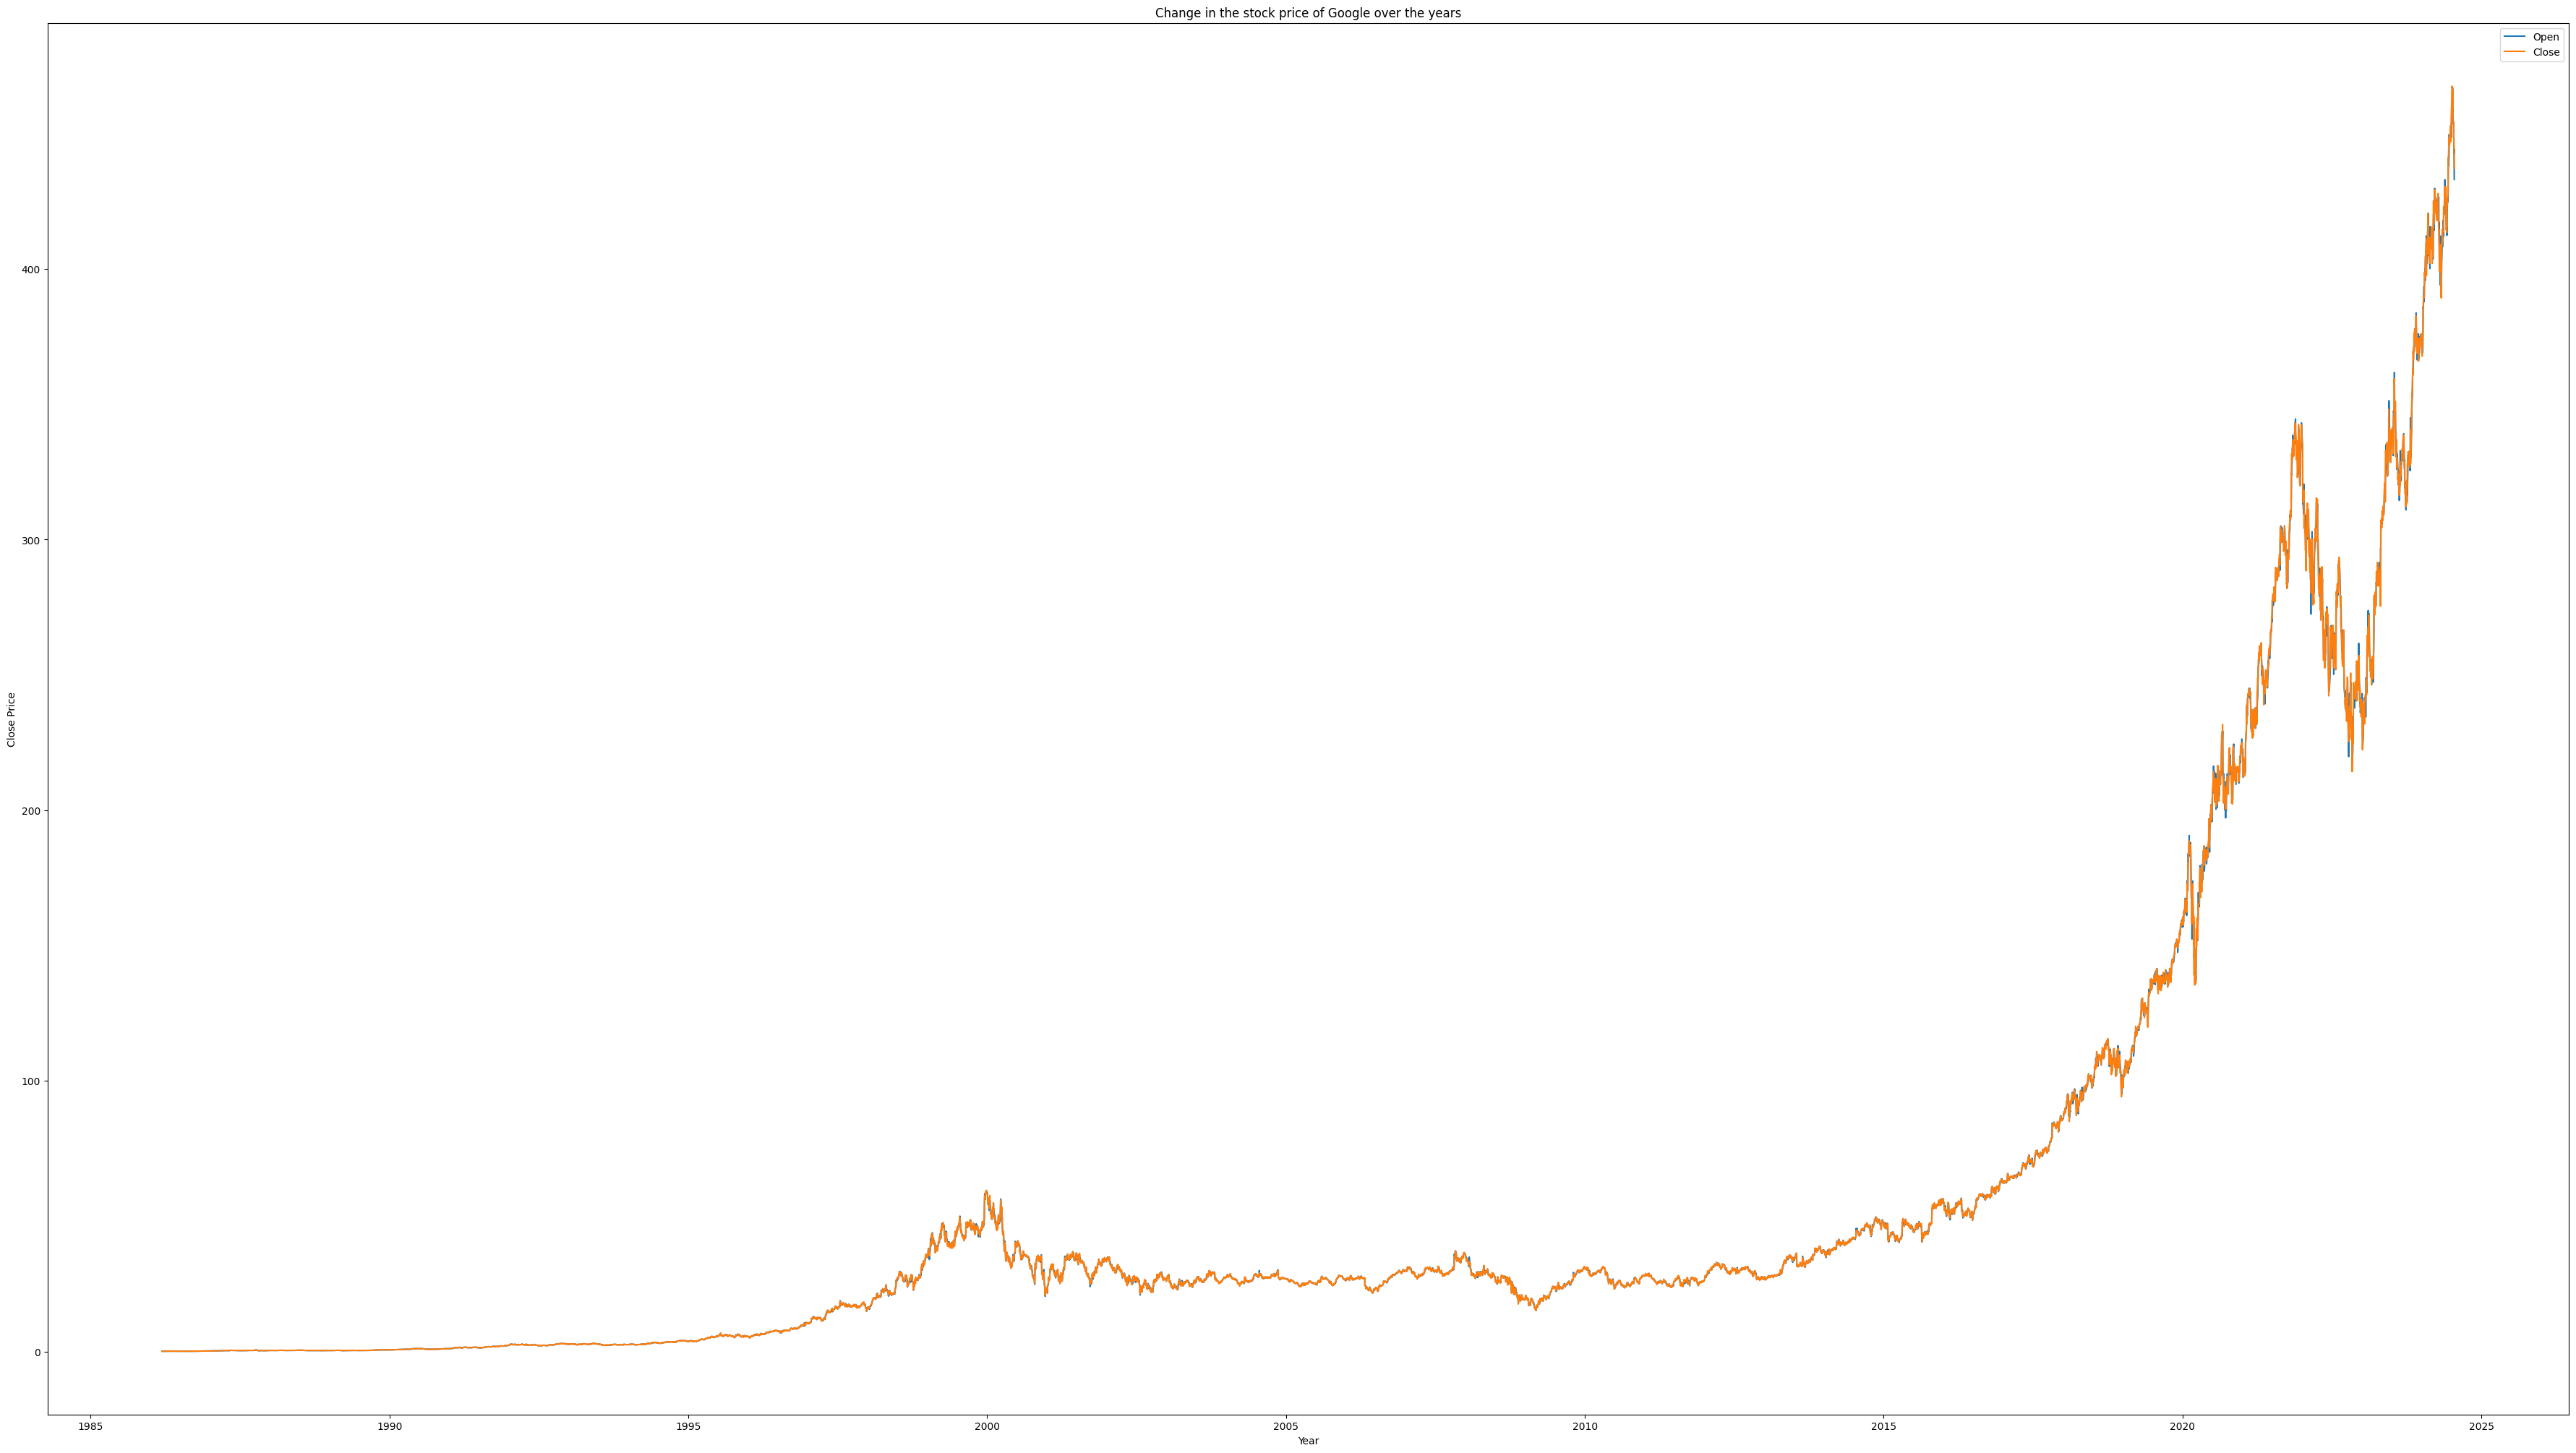

In [106]:
plt.figure(figsize=(45,25))
plt.plot(df['Date'],df['Open'], label='Open')
plt.plot(df['Date'],df['Close'], label='Close')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.legend()
plt.title('Change in the stock price of Google over the years')

<Axes: xlabel='Date', ylabel='Rolling Average'>

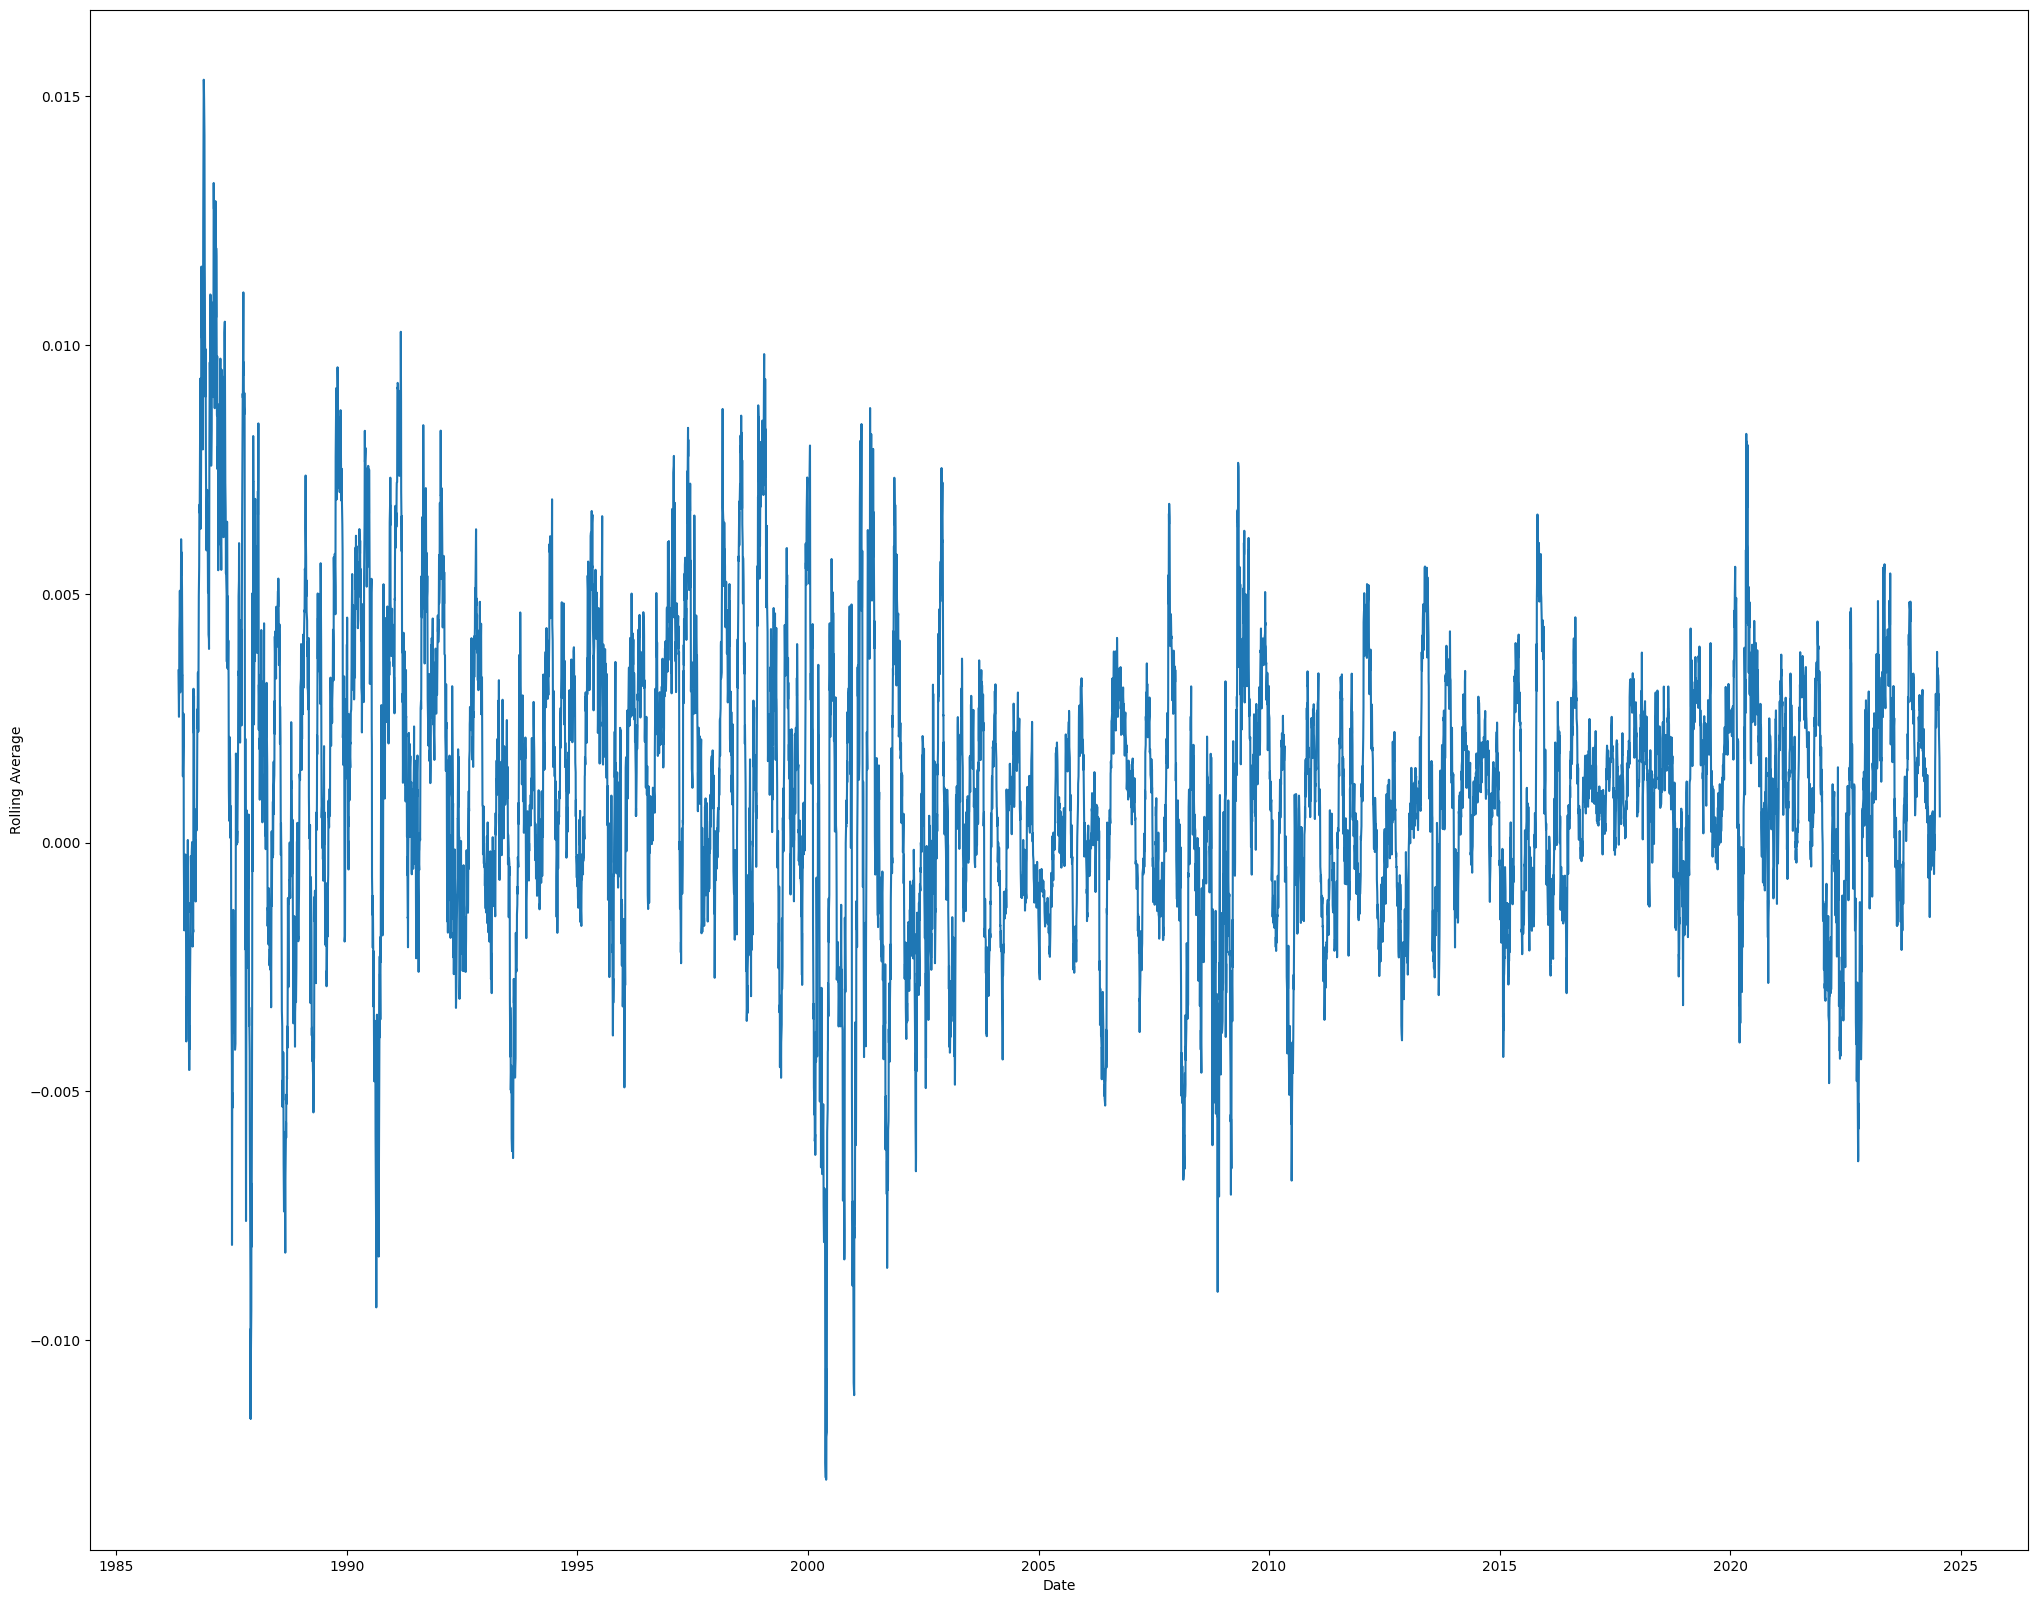

In [107]:
df['Returns'] = df['Close'].pct_change()
df['Rolling Average'] = df['Returns'].rolling(window=40).mean()
plt.figure(figsize=(25,20))
sns.lineplot(x='Date', y='Rolling Average',data=df)

<Axes: >

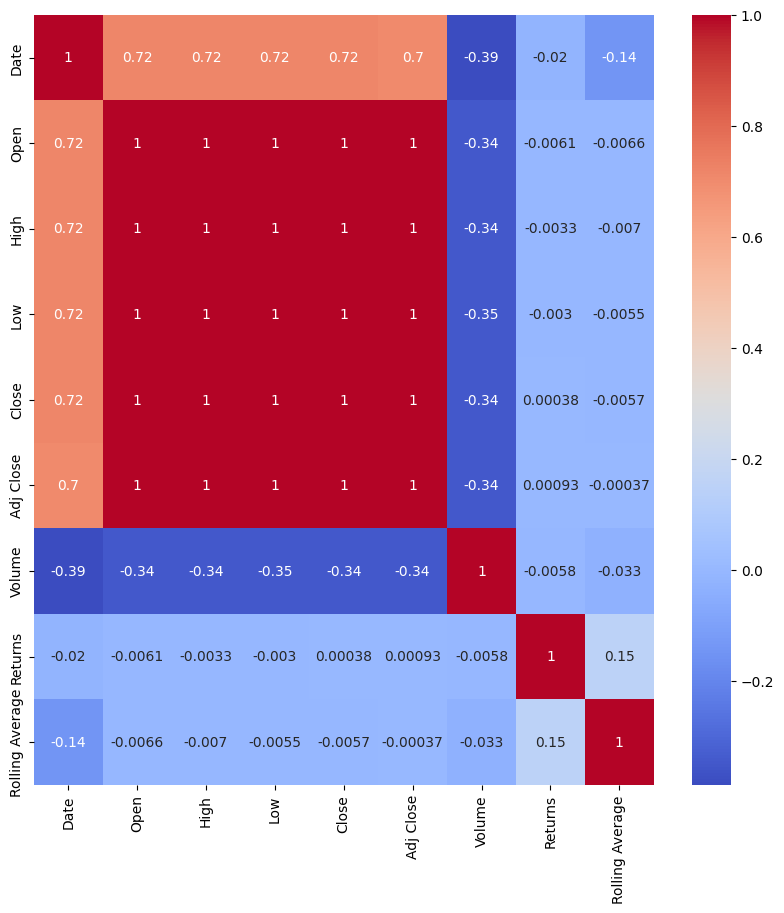

In [108]:
corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True,cmap='coolwarm')

In [109]:
scaler= StandardScaler()
df['Returns'] = scaler.fit_transform(df['Returns'].values.reshape(-1,1))
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Returns,Rolling Average
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800,NaN,NaN
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000,1.638571,NaN
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200,0.764705,NaN
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400,-1.255597,NaN
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400,-0.874963,NaN


In [110]:
df['Returns'] = df['Returns'].fillna(df['Returns'].mean())
df['Rolling Average'] = df['Rolling Average'].fillna(df['Rolling Average'].mean())

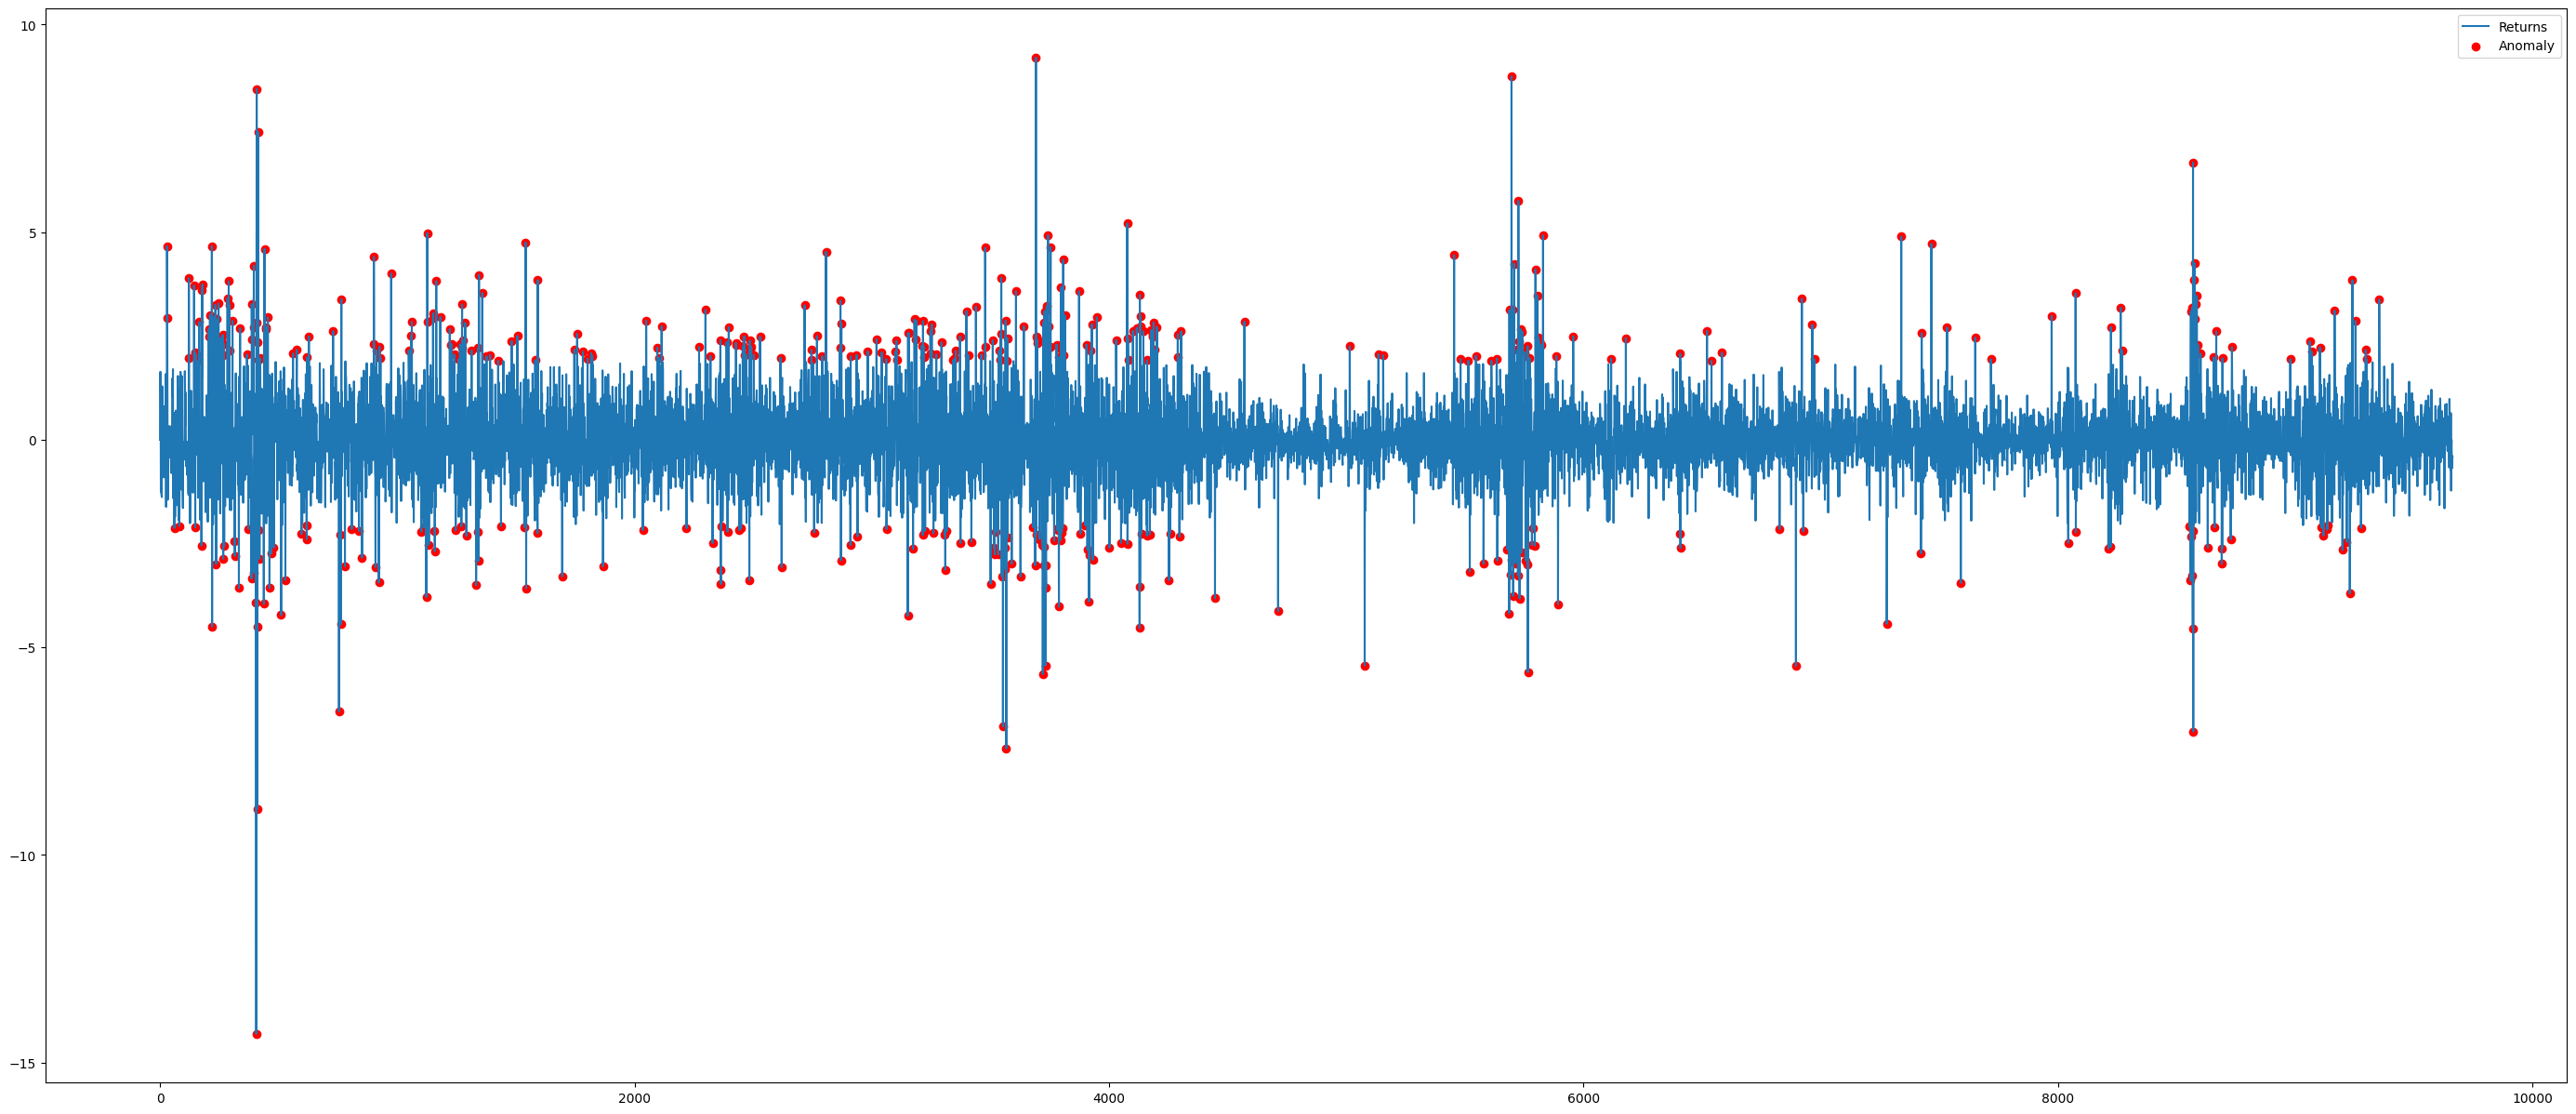

In [111]:
model=IsolationForest(contamination=0.05)
model.fit(df[['Returns']])

df['Anomaly'] = model.predict(df[['Returns']])
df['Anomaly'] = df['Anomaly'].map({1:0,-1:1})

plt.figure(figsize=(35,15))
plt.plot(df.index,df['Returns'],label='Returns')
plt.scatter(df[df['Anomaly']==1].index,df[df['Anomaly']==1]['Returns'],color='red')
plt.legend(['Returns','Anomaly'])
plt.show()

In [112]:
df[df["Anomaly"]==1]

,Date,Open,High,Low,Close,Adj Close,Volume,Returns,Rolling Average,Anomaly
29,1986-04-24,0.100260,0.111979,0.099826,0.110243,0.068098,62352000,4.661260,0.001095,1
30,1986-04-25,0.111111,0.121962,0.111111,0.117188,0.072388,85795200,2.930079,0.001095,1
60,1986-06-09,0.118924,0.118924,0.113715,0.113715,0.070242,12672000,-2.125086,0.003576,1
81,1986-07-09,0.101563,0.101563,0.096354,0.097222,0.060055,46137600,-2.074953,-0.003129,1
121,1986-09-04,0.095486,0.101563,0.095486,0.101563,0.062736,39427200,3.892917,0.001355,1
...,...,...,...,...,...,...,...,...,...,...
9255,2022-11-30,240.570007,255.330002,239.860001,255.139999,251.976257,47594200,2.865060,0.001036,1
9278,2023-01-04,232.279999,232.869995,225.960007,229.100006,226.259186,50623400,-2.122347,0.001112,1
9298,2023-02-02,258.820007,264.690002,257.250000,264.600006,261.319000,39940400,2.167394,0.001596,1
9301,2023-02-07,260.529999,268.769989,260.079987,267.559998,264.242249,50841400,1.937247,0.002177,1


# Evaluation

In [113]:
X=df[["Returns"]]
dbscan=DBSCAN(eps=0.1,min_samples=5)
lbls=dbscan.fit_predict(X)
df['Cluster Labels']=lbls
slh_avg=silhouette_score(X,lbls)
print(f"The silhouette Score is : {slh_avg:.2f}")

The silhouette Score is : 0.68


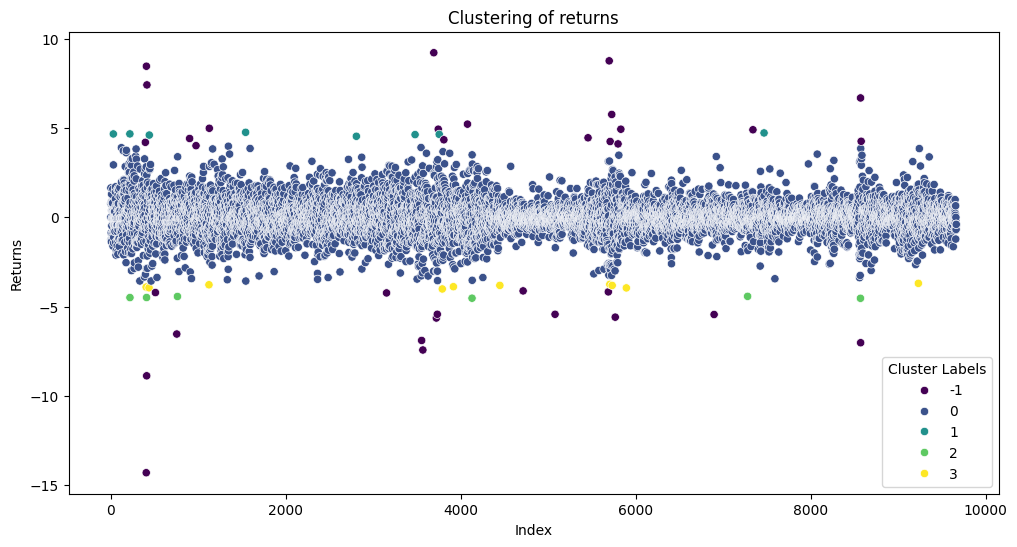

In [114]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=df.index, y=df['Returns'], hue=df['Cluster Labels'], palette='viridis', legend='full')
plt.title("Clustering of returns")
plt.xlabel('Index')
plt.ylabel('Returns')
plt.show()